# Análise de caminho mais curto em redes de passes

#### Especificações de Hardware

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13298580 kB


In [ ]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
overlay         116G   42G   75G  36% /
tmpfs            68M     0   68M   0% /dev
shm             6.2G     0  6.2G   0% /dev/shm
/dev/root       2.1G  1.3G  851M  59% /sbin/docker-init
tmpfs           6.9G   33k  6.9G   1% /var/colab
/dev/sda1        87G   46G   42G  53% /etc/hosts
tmpfs           6.9G     0  6.9G   0% /proc/acpi
tmpfs           6.9G     0  6.9G   0% /proc/scsi
tmpfs           6.9G     0  6.9G   0% /sys/firmware


In [ ]:
!uname -a

Linux c9c04c6a3bf3 5.4.188+ #1 SMP Sun Apr 24 10:03:06 PDT 2022 x86_64 x86_64 x86_64 GNU/Linux


## Preparação de Dados

### Importando Biblotecas

In [ ]:
import pandas as pd #Usada para manipulação dos dados
import json #Usada para manipulação de dados json
import networkx as nx #Usada nos plots dos grafos
import matplotlib.pyplot as plt #Usada em plots
import seaborn as sns #Usada no plot das matrizes de adjacência
!pip install wget
import wget #Usada para o download do arquivo de testes
import os #Usada na checagem se existem arquivos de teste já baixados no ambiente e na remoção do arquivo caso exista
import time as time_lib #Usada para medir o tempo de execução do programa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download de Dados

Abaixo o download do arquivo com dados de eventos da partida.

Para mudar o arquivo de testes, por favor, realize os seguintes passos: 
- Visite o [repositório de dados abertos do StatsBomb;](https://github.com/statsbomb/open-data)

- Dirija-se ao [diretório `data/events`](https://github.com/statsbomb/open-data/tree/master/data/events);

- Clique em um dos arquivos presentes no repositório;

- Clique em `View Raw` presente na área apresentada na imagem abaixo;

![Clique em view raw](https://docs.google.com/uc?export=download&id=1tzTgx3lvPEtzJYdirTcCHVgaJS3Iup7K)

- Copie a url da página que foi carregada após o clique - url destacada na imagem abaixo;
![URL do arquivo de teste](https://docs.google.com/uc?export=download&id=1G5sg8rmnmDQ0-A7gJx7-nbC9bnQdDzlH)

- E cole na caixa de texto que solicita a url do arquivo de teste.

In [ ]:
url = input("Digite a url do arquivo de teste que deseja utilizar ou deixe em branco para o arquivo padrão: ")
if url=="":
  url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/15946.json'

if os.path.isfile('teste.json'):
    os.remove('teste.json')
wget.download(url, 'teste.json')

Digite a url do arquivo de teste que deseja utilizar ou deixe em branco para o arquivo padrão: 


'teste.json'

Abaixo o download da imagem do campo de futebol usada nos plots do programa

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WhjVhgNgjN6TZRkjnlgOZN_7QIoyMJkf' -O "image_pitch.png"

--2022-07-15 12:52:19--  https://docs.google.com/uc?export=download&id=1WhjVhgNgjN6TZRkjnlgOZN_7QIoyMJkf
Resolving docs.google.com (docs.google.com)... 108.177.125.138, 108.177.125.139, 108.177.125.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ef7812r9p9tnt8ivnps6uhqlvsvrshof/1657889475000/04943223576839391483/*/1WhjVhgNgjN6TZRkjnlgOZN_7QIoyMJkf?e=download&uuid=4ad5be8e-51be-42cc-80ab-bddd148346ba [following]
--2022-07-15 12:52:21--  https://doc-04-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ef7812r9p9tnt8ivnps6uhqlvsvrshof/1657889475000/04943223576839391483/*/1WhjVhgNgjN6TZRkjnlgOZN_7QIoyMJkf?e=download&uuid=4ad5be8e-51be-42cc-80ab-bddd148346ba
Resolving doc-04-18-docs.googleusercontent.com (doc-04-18-docs.googleusercontent.com)... 142.250.157.132, 2404:

### Leitura do json e transformação em Dataframe

#### Informações sobre passes

In [ ]:
with open('teste.json','r') as g:
    data = json.load(g)

In [ ]:
df_nested = pd.json_normalize(data, max_level=2)

In [ ]:
df_nested.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type.id', 'type.name',
       ...
       'substitution.outcome.name', 'substitution.replacement.id',
       'substitution.replacement.name', 'pass.cut_back', 'shot.one_on_one',
       'foul_committed.advantage', 'foul_won.advantage',
       'foul_committed.type.id', 'foul_committed.type.name',
       'pass.goal_assist'],
      dtype='object', length=105)

In [ ]:
df_nested

,id,index,period,timestamp,minute,second,possession,duration,type.id,type.name,...,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,pass.cut_back,shot.one_on_one,foul_committed.advantage,foul_won.advantage,foul_committed.type.id,foul_committed.type.name,pass.goal_assist
0,ce508a95-38d3-4248-a50e-dc8d7e23230c,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39abd1c2-2575-41be-ae79-3e936eead529,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1148e967-380f-421f-97f0-d0c820c72984,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cf6876d-7c50-4d64-b999-e2a039641c81,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34208ade-2af4-45c3-970e-655937cad938,5,1,00:00:00.098,0,0,2,1.909000,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3997,be8a2725-6a34-45d5-8a49-5c9e0208e805,3998,2,00:46:41.244,91,41,144,0.525000,17,Pressure,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,55d71847-9511-4417-aea9-6f415e279011,3999,2,00:46:42.770,91,42,144,0.497348,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3999,f93a1612-e2de-4efe-b202-6c4a178eebad,4000,2,00:46:43.268,91,43,144,0.000000,23,Goal Keeper,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000,e1cc4d5e-ba55-4b6b-88cc-dae13311c1d9,4001,2,00:47:32.053,92,32,144,0.000000,34,Half End,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pass= df_nested[df_nested["pass.recipient.name"].notna()]

#### Informações de Localização de Jogadores

In [ ]:
df_location = df_nested[df_nested["location"].notna()]

In [ ]:
df_pass.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type.id', 'type.name',
       ...
       'substitution.outcome.name', 'substitution.replacement.id',
       'substitution.replacement.name', 'pass.cut_back', 'shot.one_on_one',
       'foul_committed.advantage', 'foul_won.advantage',
       'foul_committed.type.id', 'foul_committed.type.name',
       'pass.goal_assist'],
      dtype='object', length=105)

In [ ]:
df_sliced = df_pass[['period', 'timestamp', 'minute', 'second',
                       'duration', 'type.name',
                       'possession_team.name', 'location', 'player.name',
                       'position.name', 'pass.recipient.name', 'pass.length', 
                       'pass.angle', 'pass.height.name', 'pass.end_location', 
                       'pass.type.name', 'pass.body_part.name', 'pass.switch', 
                       'pass.outcome.name', 'pass.aerial_won']]

In [ ]:
df_pass = df_sliced
df_pass

,period,timestamp,minute,second,duration,type.name,possession_team.name,location,player.name,position.name,pass.recipient.name,pass.length,pass.angle,pass.height.name,pass.end_location,pass.type.name,pass.body_part.name,pass.switch,pass.outcome.name,pass.aerial_won
4,1,00:00:00.098,0,0,1.909,Pass,Deportivo Alavés,"[61.0, 41.0]",Jonathan Rodríguez Menéndez,Left Midfield,Guillermo Alfonso Maripán Loaysa,29.154760,-2.601173,Ground Pass,"[36.0, 26.0]",Kick Off,Left Foot,NaN,NaN,NaN
7,1,00:00:03.497,0,3,3.288,Pass,Deportivo Alavés,"[36.0, 29.0]",Guillermo Alfonso Maripán Loaysa,Left Center Back,Rubén Sobrino Pozuelo,66.603300,0.721655,High Pass,"[86.0, 73.0]",NaN,Right Foot,True,Incomplete,NaN
9,1,00:00:06.785,0,6,1.646,Pass,Barcelona,"[35.0, 8.0]",Sergio Busquets i Burgos,Right Center Midfield,Ivan Rakitić,13.000000,1.570796,High Pass,"[35.0, 21.0]",Recovery,Head,NaN,NaN,NaN
11,1,00:00:08.431,0,8,1.145,Pass,Barcelona,"[36.0, 21.0]",Ivan Rakitić,Left Center Midfield,Ousmane Dembélé,19.000000,-1.570796,Low Pass,"[36.0, 2.0]",NaN,Head,NaN,NaN,NaN
15,1,00:00:10.433,0,10,0.717,Pass,Barcelona,"[34.0, 3.0]",Ousmane Dembélé,Left Midfield,Jordi Alba Ramos,8.062258,-3.017238,Ground Pass,"[26.0, 2.0]",NaN,Right Foot,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3981,2,00:46:23.599,91,23,1.809,Pass,Barcelona,"[77.0, 78.0]",Sergi Roberto Carnicer,Right Back,Arturo Erasmo Vidal Pardo,11.704700,-2.792822,Ground Pass,"[66.0, 74.0]",NaN,Right Foot,NaN,NaN,NaN
3984,2,00:46:27.914,91,27,1.378,Pass,Barcelona,"[66.0, 74.0]",Arturo Erasmo Vidal Pardo,Right Center Midfield,Ivan Rakitić,14.317822,-2.003204,Ground Pass,"[60.0, 61.0]",NaN,Right Foot,NaN,NaN,NaN
3987,2,00:46:31.395,91,31,2.833,Pass,Barcelona,"[64.0, 55.0]",Ivan Rakitić,Center Defensive Midfield,Jordi Alba Ramos,55.470715,-1.082960,High Pass,"[90.0, 6.0]",NaN,Right Foot,True,NaN,NaN
3990,2,00:46:35.127,91,35,0.852,Pass,Barcelona,"[92.0, 6.0]",Jordi Alba Ramos,Left Back,Luis Alberto Suárez Díaz,21.023796,1.618380,Ground Pass,"[91.0, 27.0]",NaN,Left Foot,NaN,NaN,NaN


In [ ]:
df_location = df_location[['location','player.name']]

In [ ]:
df_location

,location,player.name
4,"[61.0, 41.0]",Jonathan Rodríguez Menéndez
5,"[36.0, 26.0]",Guillermo Alfonso Maripán Loaysa
6,"[36.0, 26.0]",Guillermo Alfonso Maripán Loaysa
7,"[36.0, 29.0]",Guillermo Alfonso Maripán Loaysa
8,"[85.0, 73.0]",Rubén Sobrino Pozuelo
...,...,...
3995,"[107.0, 45.0]",Lionel Andrés Messi Cuccittini
3996,"[107.0, 45.0]",Lionel Andrés Messi Cuccittini
3997,"[13.0, 41.0]",Guillermo Alfonso Maripán Loaysa
3998,"[112.0, 34.6]",Lionel Andrés Messi Cuccittini


In [ ]:
df_pass.iat[0,10]

'Guillermo Alfonso Maripán Loaysa'

#### Informações sobre Starting XI



In [ ]:
df_starting = df_nested[:2]

In [ ]:
df_sliced = df_starting[['team.name', 'tactics.formation', 'tactics.lineup']]

In [ ]:
list_players = df_sliced.iat[0,2]
list_players

[{'jersey_number': 1,
  'player': {'id': 20055, 'name': 'Marc-André ter Stegen'},
  'position': {'id': 1, 'name': 'Goalkeeper'}},
 {'jersey_number': 2,
  'player': {'id': 6374, 'name': 'Nélson Cabral Semedo'},
  'position': {'id': 2, 'name': 'Right Back'}},
 {'jersey_number': 3,
  'player': {'id': 5213, 'name': 'Gerard Piqué Bernabéu'},
  'position': {'id': 3, 'name': 'Right Center Back'}},
 {'jersey_number': 23,
  'player': {'id': 5492, 'name': 'Samuel Yves Umtiti'},
  'position': {'id': 5, 'name': 'Left Center Back'}},
 {'jersey_number': 18,
  'player': {'id': 5211, 'name': 'Jordi Alba Ramos'},
  'position': {'id': 6, 'name': 'Left Back'}},
 {'jersey_number': 20,
  'player': {'id': 6379, 'name': 'Sergi Roberto Carnicer'},
  'position': {'id': 12, 'name': 'Right Midfield'}},
 {'jersey_number': 5,
  'player': {'id': 5203, 'name': 'Sergio Busquets i Burgos'},
  'position': {'id': 13, 'name': 'Right Center Midfield'}},
 {'jersey_number': 4,
  'player': {'id': 5470, 'name': 'Ivan Rakitić'

In [ ]:
list_players = df_sliced.iat[0,2]
barcelona_players = []
for player_data in list_players:
    barcelona_players.append((player_data['player']['name']).split()[-1])
barcelona_players

['Stegen',
 'Semedo',
 'Bernabéu',
 'Umtiti',
 'Ramos',
 'Carnicer',
 'Burgos',
 'Rakitić',
 'Dembélé',
 'Díaz',
 'Cuccittini']

In [ ]:
list_players = df_sliced.iat[1,2]
alaves_players = []
for player_data in list_players:
    alaves_players.append((player_data['player']['name']).split()[-1])
alaves_players

['Flores',
 'Padilla',
 'Cisneros',
 'Loaysa',
 'Sánchez',
 'Rojas',
 'Pérez',
 'Wakaso',
 'Sánchez',
 'Menéndez',
 'Pozuelo']

#### Coletando informações sobre posições de jogadores

In [ ]:
teste = df_pass.loc[df_pass["player.name"].str.split().str[-1] == barcelona_players[0]]
teste["location"].values[0]

[14.0, 28.0]

In [ ]:
barca_avg_location = {}
for player in barcelona_players:
    player_interactions = df_location.loc[df_location["player.name"].str.split().str[-1] == player]
    locations = player_interactions["location"].values
    x_avg = 0
    y_avg = 0
    for location in locations:
        x = location[0]
        y = location[1]
        x_avg += x
        y_avg += y
    x_avg = x_avg / len(locations)
    y_avg = y_avg / len(locations)
    barca_avg_location[player] = [x_avg, 80-y_avg]
barca_avg_location

{'Bernabéu': [51.716425120772946, 26.046376811594207],
 'Burgos': [67.54822134387352, 37.60118577075099],
 'Carnicer': [74.49469964664311, 15.310954063604242],
 'Cuccittini': [84.55931677018631, 21.629813664596284],
 'Dembélé': [88.48204081632653, 59.41591836734693],
 'Díaz': [90.6461038961039, 42.416233766233766],
 'Rakitić': [67.98444444444445, 42.48518518518519],
 'Ramos': [73.31750000000001, 67.5775],
 'Semedo': [72.43434343434343, 9.97979797979798],
 'Stegen': [10.680882352941177, 36.30882352941177],
 'Umtiti': [46.52, 56.09142857142857]}

In [ ]:
alaves_avg_location = {}
for player in alaves_players:
    player_interactions = df_location.loc[df_location["player.name"].str.split().str[-1] == player]
    locations = player_interactions["location"].values
    x_avg = 0
    y_avg = 0
    for location in locations:
        x = location[0]
        y = location[1]
        x_avg += x
        y_avg += y
    x_avg = x_avg / len(locations)
    y_avg = y_avg / len(locations)
    alaves_avg_location[player] = [x_avg, 80-y_avg]
alaves_avg_location

{'Cisneros': [27.09777777777778, 30.69777777777778],
 'Flores': [6.086666666666667, 38.55166666666666],
 'Loaysa': [27.732142857142858, 52.75535714285714],
 'Menéndez': [54.320388349514566, 65.07766990291262],
 'Padilla': [34.72439024390244, 15.102439024390236],
 'Pozuelo': [59.71140350877193, 38.704385964912284],
 'Pérez': [49.8515625, 22.3046875],
 'Rojas': [42.60166666666667, 49.47666666666667],
 'Sánchez': [47.74337899543379, 55.051598173515984],
 'Wakaso': [48.4664, 26.868000000000002]}

## Retorno de Informações

### Plots de informações prévias

#### Plot starting XI

In [ ]:
alaves_net = nx.Graph()
for player, position in alaves_avg_location.items():
    alaves_net.add_node(player, pos=position)

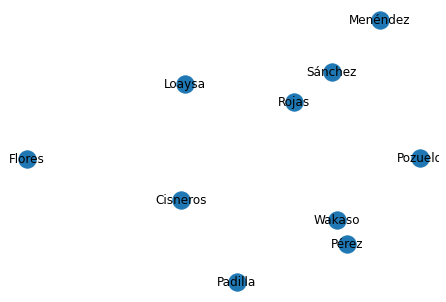

In [ ]:
nx.draw(alaves_net, nx.get_node_attributes(alaves_net, 'pos'), with_labels=True, node_size=300)

In [ ]:
barca_net = nx.DiGraph()
for player, position in barca_avg_location.items():
    barca_net.add_node(player, pos=position)

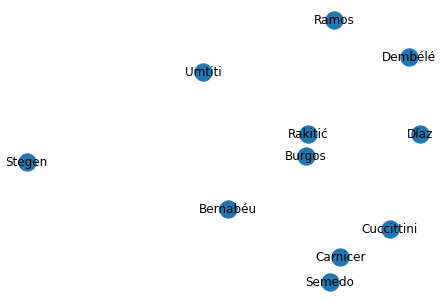

In [ ]:
nx.draw(barca_net, nx.get_node_attributes(barca_net, 'pos'), with_labels=True, node_size=300)

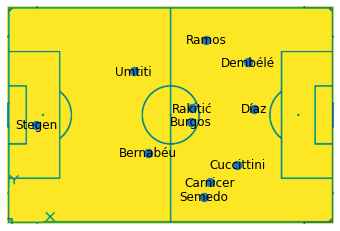

In [ ]:
img = plt.imread("image_pitch.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 120, -0, 80])
nx.draw(barca_net, nx.get_node_attributes(barca_net, 'pos'), with_labels=True, node_size=70)
plt.show()

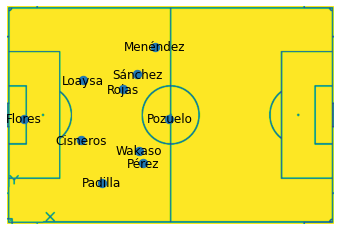

In [ ]:
img = plt.imread("image_pitch.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 120, -0, 80])
nx.draw(alaves_net, nx.get_node_attributes(alaves_net, 'pos'), with_labels=True, node_size=70)
plt.show()

#### Adicionando arcos aos Grafos Plotados 

##### Construção de Matrizes de Adjacência

In [ ]:
mat_adjac_bar = []
for p1 in range (len(barcelona_players)):
  aux = []
  for p2 in range (len(barcelona_players)):
    subset = df_pass[(df_pass['player.name'].str.split().str[-1] == barcelona_players[p1]) &
                     (df_pass['pass.recipient.name'].str.split().str[-1] == barcelona_players[p2])]
    aux.append(subset['player.name'].count())
  mat_adjac_bar.append(aux)


Abaixo uma visualização da estrutura de Adjacências que está sendo montadas

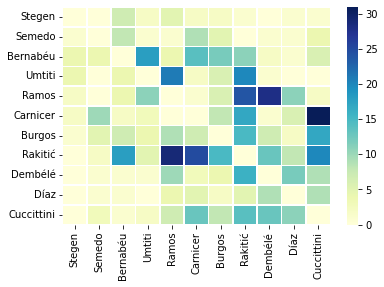

In [ ]:
ax = sns.heatmap(mat_adjac_bar, linewidth=0.5, xticklabels=barcelona_players,
                 yticklabels=barcelona_players, cmap="YlGnBu")
plt.show()

In [ ]:
for row in range(len(mat_adjac_bar)):
  for item in range(len(mat_adjac_bar[row])):
    if (mat_adjac_bar[row][item]>0):
      barca_net.add_weighted_edges_from([(barcelona_players[row],
                                          barcelona_players[item],
                                          90/mat_adjac_bar[row][item])])

In [ ]:
mat_adjac_ala = []
for p1 in range (len(alaves_players)):
  aux = []
  for p2 in range (len(alaves_players)):
    subset = df_pass[(df_pass['player.name'].str.split().str[-1] == alaves_players[p1]) &
                     (df_pass['pass.recipient.name'].str.split().str[-1] == alaves_players[p2])]
    aux.append(subset['player.name'].count())
  mat_adjac_ala.append(aux)


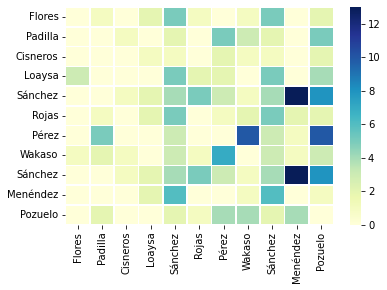

In [ ]:
ax = sns.heatmap(mat_adjac_ala, linewidth=0.5, xticklabels=alaves_players,
                 yticklabels=alaves_players, cmap="YlGnBu")
plt.show()

In [ ]:
for row in range(len(mat_adjac_ala)):
  for item in range(len(mat_adjac_ala[row])):
    if (mat_adjac_ala[row][item]>0):
      alaves_net.add_weighted_edges_from([(alaves_players[row],
                                          alaves_players[item],
                                          90/mat_adjac_ala[row][item])])

#### Plot de Redes de Passes

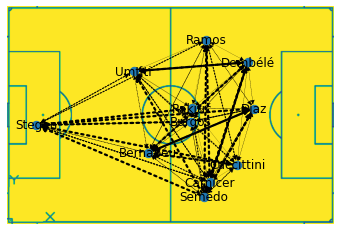

In [ ]:
img = plt.imread("image_pitch.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 120, -0, 80])
pos = nx.spring_layout(barca_net)
weights = [x / 40 for x in list(nx.get_edge_attributes(barca_net,'weight').values())]
nx.draw(barca_net, nx.get_node_attributes(barca_net, 'pos'), with_labels=True,
        node_size=70,width=weights, arrows=True, arrowstyle='-|>', style=':')
plt.show()

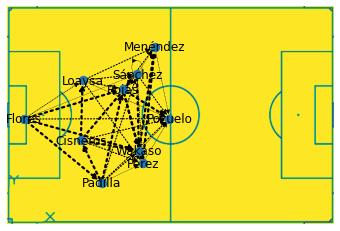

In [ ]:
img = plt.imread("image_pitch.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 120, -0, 80])
pos = nx.spring_layout(alaves_net)
weights = [x / 40 for x in list(nx.get_edge_attributes(alaves_net,'weight').values())]
nx.draw(alaves_net, nx.get_node_attributes(alaves_net, 'pos'), with_labels=True,
        node_size=70,width=weights, arrows=True, arrowstyle='-|>', style=':')
plt.show()

Abaixo as Redes de Passes de ambos os times sobrepostas

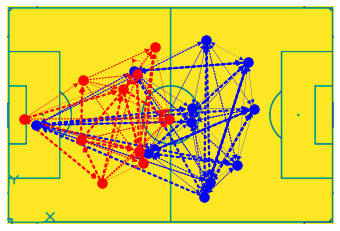

In [ ]:
img = plt.imread("image_pitch.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 120, -0, 80])
pos = nx.spring_layout(alaves_net)
weights = [x / 40 for x in list(nx.get_edge_attributes(barca_net,'weight').values())]
nx.draw(barca_net, nx.get_node_attributes(barca_net, 'pos'), with_labels=False,
        node_size=90,width=weights, arrows=True, arrowstyle='-|>', style=':',
        node_color='b', edge_color='b')
weights = [x / 40 for x in list(nx.get_edge_attributes(alaves_net,'weight').values())]
nx.draw(alaves_net, nx.get_node_attributes(alaves_net, 'pos'), with_labels=False,
        node_size=90,width=weights, arrows=True, arrowstyle='-|>', style=':',
        node_color='r', edge_color='r')
plt.show()

## Aplicação do Algoritmo para caminho mais curto

### Funções Auxiliares

In [ ]:
def return_successors(players_names, mat_adjac, player):
  succ = []
  for i in range (len(mat_adjac[players_names.index(player)])):
    if mat_adjac[players_names.index(player)][i]>0:
      succ.append(players_names[i])
  return succ

In [ ]:
def get_edge_weight(p1_name, p2_name, mat_adjac, players_names):
  dist = 90/mat_adjac[players_names.index(p1_name)][players_names.index(p2_name)]
  return dist

In [ ]:
def get_v_minimo(fila_jogadores, distancia_dict):
  menor = 91
  jogador_m = None
  for jogador, dist in distancia_dict.items():
    if (menor > dist and jogador in fila_jogadores):
      menor = dist
      jogador_m = jogador
  return jogador_m

In [ ]:
def plot_caminho(localizacao, caminho, players_names, mat_adjac):
  caminho_net = nx.DiGraph()
  for player, position in localizacao.items():
    if player in caminho:
      caminho_net.add_node(player, pos=position)
  for i in range(len(caminho)):
    if(i==len(caminho)-1):
      break
    peso = 90/mat_adjac[players_names.index(caminho[i])][players_names.index(caminho[i+1])]
    caminho_net.add_weighted_edges_from([(caminho[i], caminho[i+1], peso)])
  img = plt.imread("image_pitch.png")
  fig, ax = plt.subplots()
  ax.imshow(img, extent=[0, 120, -0, 80])
  pos = nx.spring_layout(caminho_net)
  weights = [x/10 for x in list(nx.get_edge_attributes(caminho_net,'weight').values())]
  nx.draw(caminho_net, nx.get_node_attributes(caminho_net, 'pos'), with_labels=True,
          node_size=70,width=weights, arrows=True, arrowstyle='-|>', style=':')
  plt.show()

In [ ]:
def write_in_file(arquivo_teste, caminho, tempo):
  f = open("output.txt", "w")
  f.write(arquivo_teste)
  f.write(caminho)
  f.write(tempo)
  f.close()


### Função para aplicação o algoritmo de Dijkstra

In [ ]:
def dijkstra(players_names, mat_adjac, nome_goleiro, nome_atacante):
  distancia = {}
  anterior = {}
  fila_jogadores = []
  for nome in players_names:
    distancia[nome] = 91
    anterior[nome] = None
    fila_jogadores.append(nome)
  
  distancia[nome_goleiro] = 0
  anterior[nome_goleiro] = 0

  while (fila_jogadores):
    v_minimo = get_v_minimo(fila_jogadores, distancia)

    if v_minimo == nome_atacante:
      caminho = []
      while (v_minimo != nome_goleiro):
        caminho.append(v_minimo)
        v_minimo = anterior[v_minimo]
      caminho.append(v_minimo)
      return caminho[::-1]

    fila_jogadores.remove(v_minimo)
    for jogador in return_successors(players_names, mat_adjac, v_minimo):
      if (jogador in fila_jogadores):
        dist_caminho = (distancia[v_minimo] +
                        get_edge_weight(v_minimo, jogador, mat_adjac,
                                        players_names))
        if (dist_caminho < distancia[jogador]):
          distancia[jogador] = dist_caminho
          anterior[jogador] = v_minimo
    

### Uso da função do algoritmo

As listas impressas abaixo servem para auxiliar a escolha dos jogadores para análise

In [ ]:
print(barcelona_players)
print(alaves_players)

['Stegen', 'Semedo', 'Bernabéu', 'Umtiti', 'Ramos', 'Carnicer', 'Burgos', 'Rakitić', 'Dembélé', 'Díaz', 'Cuccittini']
['Flores', 'Padilla', 'Cisneros', 'Loaysa', 'Sánchez', 'Rojas', 'Pérez', 'Wakaso', 'Sánchez', 'Menéndez', 'Pozuelo']


Selecione qual dos times deseja analisar (1- Time da casa; 2- Time de Fora): 2
Digite o nome do ponto inicial: Flores
Digite o nome do ponto final: Wakaso
O caminho mais curto é:
['Flores', 'Sánchez', 'Pozuelo', 'Wakaso']
--- 0.0002803802490234375 seconds ---


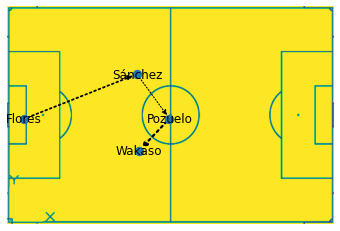

Arquivo de saída: 'output.txt'


In [ ]:
time_esc = int(input("Selecione qual dos times deseja analisar (1- Time da casa; 2- Time de Fora): "))
source = input("Digite o nome do ponto inicial: ")
target = input("Digite o nome do ponto final: ")

if time_esc == 1:
  if (source not in barcelona_players) or (target not in barcelona_players):
    print("Por favor digite parâmetros válidos!")
  else:
    print("O caminho mais curto é:")
    start_time = time_lib.time()
    caminho_mais_curto = dijkstra(barcelona_players, mat_adjac_bar,
                                  source, target)
    end_time = time_lib.time()
    print(caminho_mais_curto)
    write_in_file(url,caminho_mais_curto,end_time-start_time)
    print("--- %s seconds ---" % (end_time - start_time))
    plot_caminho(barca_avg_location, caminho_mais_curto, barcelona_players, mat_adjac_bar)
    print("Arquivo de saída: 'output.txt'")
else:
  if time_esc == 2:
    if (source not in alaves_players) or (target not in alaves_players):
      print("Por favor digite parâmetros válidos!")
    else:
      print("O caminho mais curto é:")
      start_time = time_lib.time()
      caminho_mais_curto = dijkstra(alaves_players, mat_adjac_ala,
                                    source, target)
      end_time = time_lib.time()
      print(caminho_mais_curto)
      write_in_file(url,str(caminho_mais_curto),str(end_time-start_time))
      print("--- %s seconds ---" % (end_time - start_time))
      plot_caminho(alaves_avg_location, caminho_mais_curto, alaves_players, mat_adjac_ala)
      print("Arquivo de saída: 'output.txt'")
  else:
    print("Por favor digite parâmetros válidos!")


## Testes em Massa

In [ ]:
numeracao_arquivos_teste = ['15946','15956','15973','15978','15986','15998',
                            '16010','16023','16029','16056','16073','16079',
                            '16086','16095','16109','16120','16131','16136',
                            '16149','16157','16173','16182','16190','16196']

In [ ]:
def get_list_players(list_players):
  players = []
  for player_data in list_players:
      players.append((player_data['player']['name']).split()[-1])
  return players

In [ ]:
id_casos_teste = []
caminhos = []
equipes = []
tempo_execucao_total = []
tempo_execucao_dijkstra = []
for numeracao in numeracao_arquivos_teste:
  start_downloads = time_lib.time()
  url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/"+numeracao+".json"
  wget.download(url, 'teste.json')
  with open('teste.json','r') as g:
    data = json.load(g)

  df_nested = pd.json_normalize(data, max_level=2)
  df_starting = df_nested[:2]
  df_sliced = df_starting[['team.name', 'tactics.formation', 'tactics.lineup']]
  end_downloads = time_lib.time()
  for i in range(2):
    start_tratamento = time_lib.time()
    if(i==0):
      list_players = df_sliced.iat[0,2]
    else:
      list_players = df_sliced.iat[1,2]
    barcelona_players = get_list_players(list_players)
    df_pass = df_nested[df_nested["pass.recipient.name"].notna()]
    df_pass = df_pass[['player.name','pass.recipient.name']]

    mat_adjac_bar = []
    for p1 in range (len(barcelona_players)):
      aux = []
      for p2 in range (len(barcelona_players)):
        subset = df_pass[(df_pass['player.name'].str.split().str[-1] == barcelona_players[p1]) &
                        (df_pass['pass.recipient.name'].str.split().str[-1] == barcelona_players[p2])]
        aux.append(subset['player.name'].count())
      mat_adjac_bar.append(aux)
    df_location = df_nested[df_nested["location"].notna()]
    df_location = df_location[['location','player.name']]
    barca_avg_location = {}
    for player in barcelona_players:
      player_interactions = df_location.loc[df_location["player.name"].str.split().str[-1] == player]
      locations = player_interactions["location"].values
      x_avg = 0
      y_avg = 0
      for location in locations:
        x = location[0]
        y = location[1]
        x_avg += x
        y_avg += y
      x_avg = x_avg / len(locations)
      y_avg = y_avg / len(locations)
    barca_avg_location[player] = [x_avg, 80-y_avg]
    end_tratamento = time_lib.time()
    start_dijkstra = time_lib.time()
    caminho_mais_curto = dijkstra(barcelona_players, mat_adjac_bar,
                                  barcelona_players[0], barcelona_players[len(barcelona_players)-1])
    end_dijkstra = time_lib.time()
    id_casos_teste.append(numeracao)
    caminhos.append(caminho_mais_curto)
    tempo_total = -start_downloads + end_downloads - start_tratamento + end_tratamento - start_dijkstra + end_dijkstra
    tempo_execucao_total.append(tempo_total)
    tempo_execucao_dijkstra.append(-start_dijkstra+end_dijkstra)
    equipes.append(i)
    print(caminho_mais_curto)
  os.remove('teste.json')
    

['Stegen', 'Bernabéu', 'Carnicer', 'Cuccittini']
['Flores', 'Sánchez', 'Pozuelo']
['López', 'Pedreño']
['Stegen', 'Bernabéu', 'Carnicer', 'Cuccittini', 'Díaz']
['Stegen', 'Bernabéu', 'Carnicer', 'Díaz']
['Werner', 'Longo']
['Rulli', 'López']
['Stegen', 'Ramos', 'Díaz']
['Stegen', 'Bernabéu', 'Díaz']
['Bounou', 'López', 'Curbelo']
['Sacristán', 'En-Nesyri']
['Stegen', 'Bernabéu', 'Carnicer', 'Mohamed']
['Stegen', 'Rakitić', 'Díaz']
['Mendibil', 'Escudero', 'Arthuer']
['Neto', 'Gameiro']
['Stegen', 'Vermaelen', 'Ramos', 'Díaz']
['Stegen', 'Díaz']
['Vaclík', 'Silva', 'Yedder']
['Stegen', 'Díaz']
['Sabata', 'Rodríguez']
['Oblak', 'Costa']
['Stegen', 'Umtiti', 'Ramos', 'Díaz']
['Stegen', 'Semedo', 'Dembélé', 'Cuccittini']
['Andrés', 'Martínez', 'Balaguero']
['Rodríguez', 'Junqué', 'Mata', 'Quintas']
['Stegen', 'Semedo', 'Díaz']
['Paredes', 'Nogales', 'Salgueiro', 'Boateng']
['Stegen', 'Dembélé', 'Cuccittini']
['Stegen', 'Semedo', 'Rakitić', 'Díaz']
['Veiga', 'González']
['Solís', 'Arnaiz']


In [ ]:
dados_teste = {'Ids Arquivos de Teste': id_casos_teste,
               'Caminho Mais Curto': caminhos, 'Equipe': equipes, 'Tempo Total': tempo_execucao_total,
               'Tempo Dijkstra': tempo_execucao_dijkstra}

df_resultados_testes = pd.DataFrame.from_dict(dados_teste)
pd.set_option('display.float_format', '{:.2E}'.format)
df_resultados_testes.head(26)

,Ids Arquivos de Teste,Caminho Mais Curto,Equipe,Tempo Total,Tempo Dijkstra
0,15946,"[Stegen, Bernabéu, Carnicer, Cuccittini]",0,1.93E+00,1.80E-04
1,15946,"[Flores, Sánchez, Pozuelo]",1,2.95E+00,1.02E-04
2,15956,"[López, Pedreño]",0,2.50E+00,9.42E-05
3,15956,"[Stegen, Bernabéu, Carnicer, Cuccittini, Díaz]",1,2.50E+00,2.11E-04
4,15973,"[Stegen, Bernabéu, Carnicer, Díaz]",0,3.78E+00,2.01E-04
5,15973,"[Werner, Longo]",1,4.19E+00,7.72E-05
6,15978,"[Rulli, López]",0,2.58E+00,9.49E-05
7,15978,"[Stegen, Ramos, Díaz]",1,2.50E+00,2.03E-04
8,15986,"[Stegen, Bernabéu, Díaz]",0,2.97E+00,1.74E-04
9,15986,"[Bounou, López, Curbelo]",1,2.78E+00,8.99E-05


In [ ]:
df_resultados_testes

,Ids Arquivos de Teste,Caminho Mais Curto,Equipe,Tempo Total,Tempo Dijkstra
0,15946,"[Stegen, Bernabéu, Carnicer, Cuccittini]",0,1.93E+00,1.80E-04
1,15946,"[Flores, Sánchez, Pozuelo]",1,2.95E+00,1.02E-04
2,15956,"[López, Pedreño]",0,2.50E+00,9.42E-05
3,15956,"[Stegen, Bernabéu, Carnicer, Cuccittini, Díaz]",1,2.50E+00,2.11E-04
4,15973,"[Stegen, Bernabéu, Carnicer, Díaz]",0,3.78E+00,2.01E-04
5,15973,"[Werner, Longo]",1,4.19E+00,7.72E-05
6,15978,"[Rulli, López]",0,2.58E+00,9.49E-05
7,15978,"[Stegen, Ramos, Díaz]",1,2.50E+00,2.03E-04
8,15986,"[Stegen, Bernabéu, Díaz]",0,2.97E+00,1.74E-04
9,15986,"[Bounou, López, Curbelo]",1,2.78E+00,8.99E-05


In [ ]:
df_resultados_testes.to_latex()

'\\begin{tabular}{lllrrr}\n\\toprule\n{} & Ids Arquivos de Teste &                              Caminho Mais Curto &  Equipe &  Tempo Total &  Tempo Dijkstra \\\\\n\\midrule\n0  &                 15946 &        [Stegen, Bernabéu, Carnicer, Cuccittini] &       0 &     1.93E+00 &        1.80E-04 \\\\\n1  &                 15946 &                      [Flores, Sánchez, Pozuelo] &       1 &     2.95E+00 &        1.02E-04 \\\\\n2  &                 15956 &                                [López, Pedreño] &       0 &     2.50E+00 &        9.42E-05 \\\\\n3  &                 15956 &  [Stegen, Bernabéu, Carnicer, Cuccittini, Díaz] &       1 &     2.50E+00 &        2.11E-04 \\\\\n4  &                 15973 &              [Stegen, Bernabéu, Carnicer, Díaz] &       0 &     3.78E+00 &        2.01E-04 \\\\\n5  &                 15973 &                                 [Werner, Longo] &       1 &     4.19E+00 &        7.72E-05 \\\\\n6  &                 15978 &                                  [Rulli,

In [ ]:
df_resultados_testes['Tempo Dijkstra'].mean()

0.00014664232730865479

In [ ]:
df_resultados_testes['Tempo Dijkstra'].std()

6.165401168328971e-05

In [ ]:
df_resultados_testes['Tempo Total'].mean()

2.7132720947265625